# DQN with `dm_control`

Here are some experiments using deep Q-Learning to solve simple continuous control tasks. I implemented [the original DQN](https://www.nature.com/articles/nature14236) and used it to solve several tasks in the [DeepMind Control Suite](https://arxiv.org/abs/1801.00690). The main ideas are:
1. Maintain a replay buffer of experiences that are drawn from for training. This decreases correlations in the training data.
2. Keep an additional Q network used for calculating targets that is updated less frequently that the main Q network. This stabalizes the updates.

Q-Learning takes the max across actions, which is not ideal for continuous action spaces. In this implementation the action space is discretized, such that each action dimension can take a value in `linspace(action_min, actions_max, action_grid)`, where `action_grid` $\in (2,3)$ in this demo. The full action space is the cartesian product of the vectors for each dimension.

The demo is organized as follows:
1. **setup**
2. **solving tasks:** pendulum, cartpole, ball in cup
3. **double DQN:** I implement [Double Q-Learning](https://arxiv.org/abs/1509.06461) and show that it increases the accuracy of action-value estimates.
4. **encouraging exploration:** To increase exploration I used a simple trick to encourage optimism in the face of uncertainty. Namely, I pretrained the network to output optimistic action-values across the state-space, which encourages exploration in the early phases of learning.  

# setup

We start by defining some utility functions that will help with plotting and training. To increase training speed I found it helpful to:
- *Train on the CPU rather than GPU.* The Q network is very small. My CPU was faster than the GPU unless batch sizes were really large.
- *Perform forward passes on Numpy*. Network forward passes ended up being much faster using numpy rather than Tensorflow (again, unless batch sizes were really large).
- *Train multiple agents in parallel*. Training results could be somewhat idiosyncratic even with the same hyperparameters, so I train 12 agents in parallel to make sure the results are robust.

In [1]:
#@title setup

%load_ext autoreload
%autoreload 2

from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from dm_control import suite
from itertools import repeat
import numpy as np

# from dm_control_tests import train_utils
# from dm_control_tests.agents import Agent
# train_utils.disable_gpu()

# plot performance over training, averaged across agents
def plot_performance(x, data):
    ax = plt.axes(xlabel='episode', ylabel='return',
                  xlim=(x[0],x[-1]), ylim=(0,1000))
    data = np.array(data)
    mean = data.mean(0)
    std = data.std(0)
    ax.plot(x, data.T, color=(0,0,0), alpha=.15)
    ax.plot(x, mean)
    ax.fill_between(x, mean+std, mean-std, alpha=.15)

# train a single agent on a particular domain and task
def train_agent(domain_and_task, agent_args, train_args, verbose=True):    
    from dm_control_tests import train_utils
    from dm_control_tests.agents import Agent
    train_utils.disable_gpu()
    
    env = suite.load(*domain_and_task)
    agent = Agent(env.observation_spec(), env.action_spec(), **agent_args)
    train_utils.initialize_buffer(agent, env, verbose=False)
    episode_num, returns = train_utils.train(agent, env, **train_args, verbose=verbose)
    return episode_num, returns, agent.q.get_weights()

# train multiple agents in parallel on a particular domain and task
def train_agents_parallel(domain_and_task, agent_args, train_args,
                         n_agents=12, n_workers=12):
    with ProcessPoolExecutor(max_workers=n_workers) as executor:    
        results = executor.map(train_agent, 
                               repeat(domain_and_task, n_agents),
                               repeat(agent_args),
                               repeat(train_args),
                               [True]+list(repeat(False, n_agents-1)))  # only verbose for first thread
        results = [r for r in results]
    episode_num = results[0][0]
    avg_returns = np.array([np.array(r[1]).mean(1) for r in results])
    weights = [r[2] for r in results]
    return episode_num, avg_returns, weights

# show a rollout for the agent with the best performance at the end of training
def show_best_agent_rollout(domain_and_task, avg_returns, weights, agent_args):
    from dm_control_tests import train_utils, plot_utils
    from dm_control_tests.agents import Agent
    train_utils.disable_gpu()
    
    env = suite.load(*domain_and_task)
    agent = Agent(env.observation_spec(), env.action_spec(), **agent_args)
    best_agent = np.argmax(avg_returns[:,-1])  # hightest return at end of training
    agent.q.set_weights(weights[best_agent])
    return plot_utils.show_rollout_jupyter(agent, env, epsilon=.05)


### training
Let's set up the hyperparameters for training. Every action dimension will be discretized into `action_grid=2` actions. This makes training fast, but it also means a given action can't be set to `0`. We will use a replay buffer of size `buffer_length=50000` that is initialized using random actions prior to training and a Q network with hidden layers of size `units_per_layer=(12,24)`.  The target Q network will be updated after every `q_update_interval=100` updates of the main Q network.

The temporal resolution of the `dm_control` environments is rather high. During exploration, especially with sparse rewards, the sequence of correctly chosen actions necessary to discover the reward may be quite long. Therefore (as in the original paper), I repeat each action `action_repeats=2` times. Furthermore, I only perform network updates every `steps_per_update=4` iterations. The updates, rather than the physics simulations, are the speed bottleneck. This allows the agent to see more episodes with the same number of updates.

I train for `episodes=200` episodes with `batch_size=64`, acting $\epsilon$-greedy with $\epsilon$ linearly annealed from `epsilon_start=1` to `epsilon_final=.1` over `epsilon_final_episode=100` episodes.

### evaluation
Finally, every `eval_interval = 10` episodes I estimate the return by averaging the return from 5 rollouts with $\epsilon = .05$. 12$ agents are trained in parallel, and I plot the average += standard deviation of the return across these agents.

In [3]:
# @title hyperparameters 

# agent
agent_args = dict(
    action_grid = 2,            # number of discrete actions per action dimension
    units_per_layer = (12,24),  # hidden units per layer
    buffer_length = 50000,
    q_update_interval = 100,    # q updates per q_target update
    learning_rate = .001,       # learning rate (adam optimizer)       
)

# training
train_args = dict(
    episodes = 200,
    eval_interval = 10,
    batch_size = 64,
    action_repeats = 2,         # repeat each action this number of times during training
    steps_per_update = 4,       # environment steps before updating q
    gamma = .99,
    epsilon_start = 1,
    epsilon_final = .1,
    epsilon_final_episode = 100,   # episode at which epsilon_final is reached
)

# solving simple tasks
will solve pendulum, swing up, and ball in cup

## cartpole (balance)

- state space only r2 and action space r1 - try this out to make sure everything is in order
- explain evaluation metrics... evaluated every n eps, avg of m eps with z epsilon

training agent...


iteration   10, avg return 161.7
iteration   20, avg return 364.6
iteration   30, avg return 396.5
iteration   40, avg return 406.0
iteration   50, avg return 764.9
iteration   60, avg return 363.6
iteration   70, avg return 604.9
iteration   80, avg return 477.5
iteration   90, avg return 316.7
iteration  100, avg return 481.2
iteration  110, avg return 431.3
iteration  120, avg return 446.2
iteration  130, avg return 450.2
iteration  140, avg return 575.5
iteration  150, avg return 606.4
iteration  160, avg return 577.4
iteration  170, avg return 653.1
iteration  180, avg return 640.3
iteration  190, avg return 617.2
iteration  200, avg return 667.5



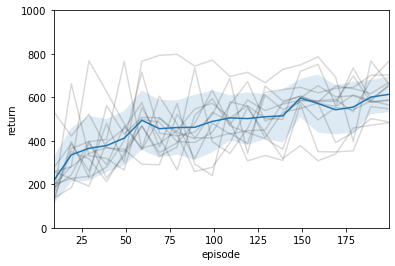

In [4]:
episode_num, avg_returns, weights = train_agents_parallel(
    ('cartpole', 'balance'), agent_args, train_args, n_agents=12, n_workers=12)
plot_performance(episode_num, avg_returns)

In [13]:
show_best_agent_rollout(('cartpole', 'balance'), avg_returns, weights, agent_args)

## cartpole (swingup)

training agent...


iteration   10, avg return 121.8
iteration   20, avg return 181.0
iteration   30, avg return 243.6
iteration   40, avg return 259.6
iteration   50, avg return 141.2
iteration   60, avg return 239.3
iteration   70, avg return 448.9
iteration   80, avg return 335.0
iteration   90, avg return 412.1
iteration  100, avg return 515.5
iteration  110, avg return 464.1
iteration  120, avg return 663.6
iteration  130, avg return 513.2
iteration  140, avg return 530.1
iteration  150, avg return 535.4
iteration  160, avg return 565.0
iteration  170, avg return 538.2
iteration  180, avg return 251.9
iteration  190, avg return 472.4
iteration  200, avg return 425.7



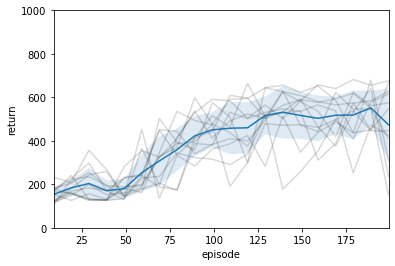

In [4]:
episode_num, avg_returns, weights = train_agents_parallel(
    ('cartpole', 'swingup'), agent_args, train_args, n_agents=12, n_workers=12)
plot_performance(episode_num, avg_returns)

In [5]:
show_best_agent_rollout(('cartpole', 'swingup'), avg_returns, weights, agent_args)

## ball in cup

In [ ]:
episode_num, avg_returns, weights = train_agents_parallel(
    ('ball_in_cup', 'catch'), agent_args, train_args, n_agents=12, n_workers=12)
plot_performance(episode_num, avg_returns)

In [ ]:
show_best_agent_rollout(('ball_in_cup', 'catch'), avg_returns, weights, agent_args)

# double q learning
max operation leads to overly optimistic q values // double q have two q functions learned on dft data samples // dqn doesn't go this far, but uses it's two q functions for action selection and evaluation... increases accuracy of q estimates, as shown in pendulum...

# optimistic initializations
for sparse reward agent needs to accidentally discover correct action sequence // can be very hard when that sequence is long // initializing optimisitic values of q can hopefully encourage initial exploration and speed up learning...

In [ ]:
train_agent(('cartpole', 'swingup'), agent_args, train_args, verbose=True)

# sandbox...

In [ ]:
# sandbox...

